# SpaceX Launch Data - Exploratory Data Analysis
## 1. Import libraries and load data

In [1]:
# Install required libraries if needed
%pip install pandas matplotlib seaborn statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [3]:
# Load data
launches = pd.read_csv("../data/clean/launches.csv")
rockets = pd.read_csv("../data/clean/rockets.csv")
launchpads = pd.read_csv("../data/clean/launchpads.csv")
payloads = pd.read_csv("../data/clean/payloads.csv")
cores = pd.read_csv("../data/clean/cores.csv")

print(f"Loaded data:")
print(f"  Launches: {len(launches)} records")
print(f"  Rockets: {len(rockets)} records")
print(f"  Launchpads: {len(launchpads)} records")
print(f"  Payloads: {len(payloads)} records")
print(f"  Cores: {len(cores)} records")
print(f"\nLaunches columns: {launches.columns.tolist()}")

Loaded data:
  Launches: 187 records
  Rockets: 4 records
  Launchpads: 6 records
  Payloads: 225 records
  Cores: 83 records

Launches columns: ['id', 'flight_number', 'name', 'date_lisbon', 'date_local', 'success', 'details', 'rocket', 'launchpad', 'core_0_id', 'core_0_flight', 'core_0_reused', 'core_0_landing_attempt', 'core_0_landing_success', 'core_0_landing_type', 'payload_0_id', 'failure_0_time', 'failure_0_altitude', 'failure_0_reason', 'fairings_reused', 'fairings_recovery_attempt', 'fairings_recovered', 'patch_small', 'patch_large', 'webcast', 'article', 'wikipedia', 'static_hash']


## 2. Launches per Quarter + Cumulative Successes

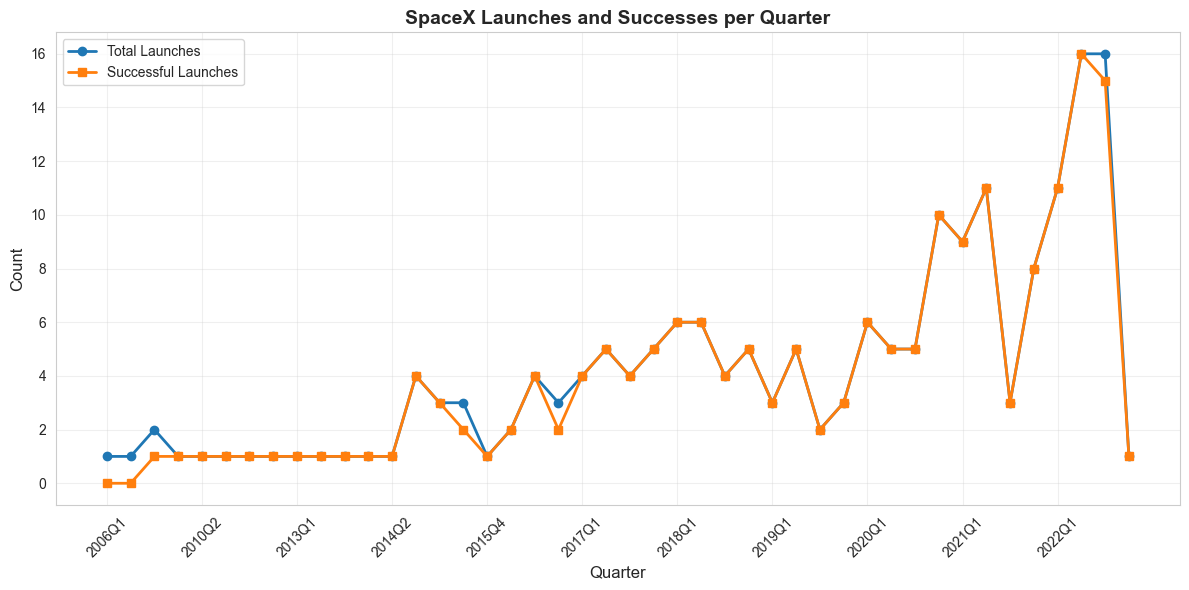


Summary Statistics:
Total Launches: 187
Successful Launches: 181
Overall Success Rate: 96.79%


In [4]:
# Work with a copy to avoid modifying original data
launches_quarterly = launches.copy()

# Handle timezone-aware datetime strings
launches_quarterly["date_lisbon"] = pd.to_datetime(launches_quarterly["date_lisbon"], utc=True)
# Convert to timezone-naive for easier manipulation
launches_quarterly["date_lisbon"] = launches_quarterly["date_lisbon"].dt.tz_localize(None)

# Create quarter column
launches_quarterly["quarter"] = launches_quarterly["date_lisbon"].dt.to_period("Q")

# Group by quarter
quarterly = launches_quarterly.groupby('quarter').agg(
    total_launches = ("id", "count"),
    successes = ("success", "sum")
).reset_index()

# Convert Period to string for plotting
quarterly['quarter_str'] = quarterly['quarter'].astype(str)

# Create the plot
plt.figure(figsize = (12, 6))
plt.plot(quarterly.index, quarterly['total_launches'], label='Total Launches', marker='o', linewidth=2)
plt.plot(quarterly.index, quarterly['successes'], label='Successful Launches', marker='s', linewidth=2)

# Show every 4th quarter for readability
tick_positions = quarterly.index[::4]
tick_labels = quarterly['quarter_str'].iloc[::4]
plt.xticks(tick_positions, tick_labels, rotation=45)

plt.title('SpaceX Launches and Successes per Quarter', fontsize=14, fontweight='bold')
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display summary statistics
print(f"\nSummary Statistics:")
print(f"Total Launches: {len(launches)}")
print(f"Successful Launches: {launches['success'].sum():.0f}")
print(f"Overall Success Rate: {(launches['success'].sum() / len(launches) * 100):.2f}%")

## 3. Success Rates by Rocket Family

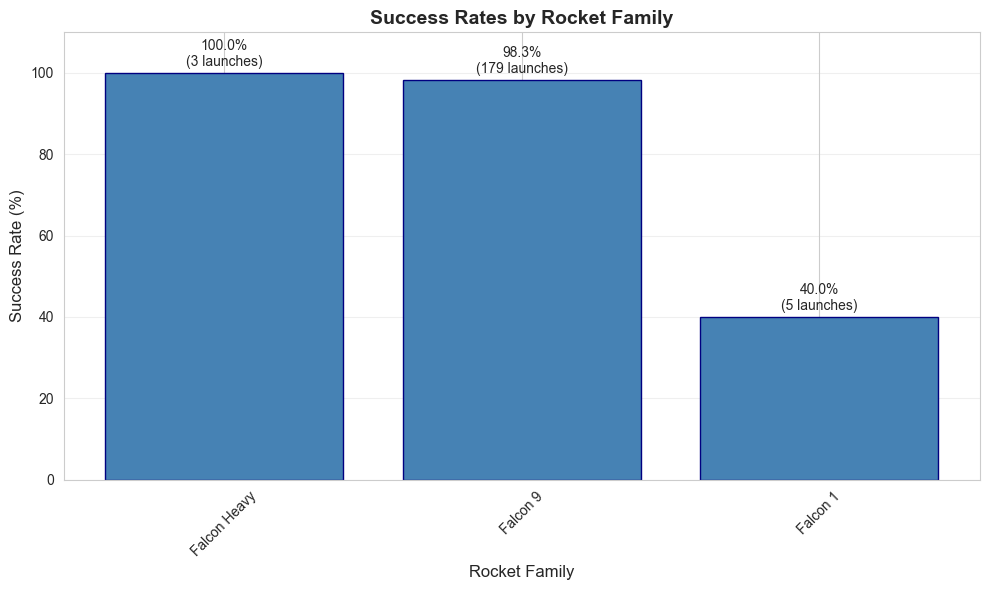


Detailed Statistics by Rocket Family:
      family  total_launches  successes  success_rate
Falcon Heavy               3          3        100.00
    Falcon 9             179        176         98.32
    Falcon 1               5          2         40.00


In [5]:
# Define rocket family classification function
def rocket_family(name):
    if pd.isna(name):
        return "Unknown"
    if re.search(r"Falcon 9", name, re.I):
        return "Falcon 9"
    elif re.search(r"Falcon Heavy", name, re.I):
        return "Falcon Heavy"
    elif re.search(r"Falcon 1", name, re.I):
        return "Falcon 1"
    elif re.search(r"Starship", name, re.I):
        return "Starship"
    else:
        return "Other"

# Apply classification
rockets_copy = rockets.copy()
rockets_copy["family"] = rockets_copy["name"].apply(rocket_family)

# Merge launches with rockets to get family information
launches_with_family = launches.merge(
    rockets_copy[["id", "family"]], 
    left_on="rocket", 
    right_on="id", 
    how="left",
    suffixes=('_launch', '_rocket')
)

# Calculate success rates by family
family_rates = launches_with_family.groupby('family').agg(
    total_launches = ("id_launch", "count"),
    successes = ("success", "sum")
).reset_index()

# Handle potential NaN values
family_rates["successes"] = family_rates["successes"].fillna(0)
family_rates["success_rate"] = (family_rates["successes"] / family_rates["total_launches"] * 100)
family_rates["success_rate"] = family_rates["success_rate"].round(2)
family_rates = family_rates.sort_values('success_rate', ascending=False)

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(family_rates['family'], family_rates['success_rate'], color='steelblue', edgecolor='navy')

# Add value labels on bars
for bar, rate, total in zip(bars, family_rates['success_rate'], family_rates['total_launches']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rate:.1f}%\n({int(total)} launches)',
             ha='center', va='bottom', fontsize=10)

plt.title("Success Rates by Rocket Family", fontsize=14, fontweight='bold')
plt.ylabel("Success Rate (%)", fontsize=12)
plt.xlabel("Rocket Family", fontsize=12)
plt.ylim(0, 110)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Display detailed statistics
print("\nDetailed Statistics by Rocket Family:")
print(family_rates.to_string(index=False))

## 4. Launchpad Reliability (Wilson 95% CI)

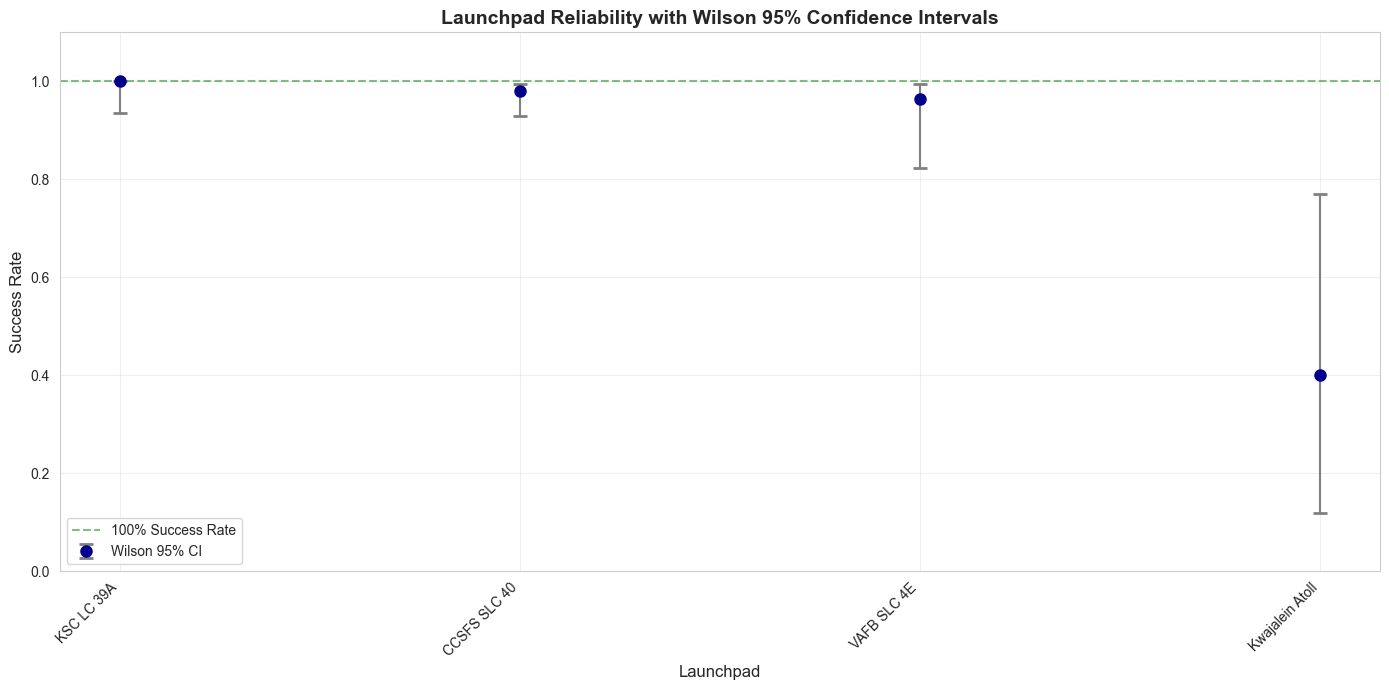


Launchpad Statistics (minimum 5 launches):
      Launchpad  Total Launches  Successes  Success Rate (%)  CI Lower (%)  CI Upper (%)
     KSC LC 39A              55         55            100.00         93.47        100.00
   CCSFS SLC 40              99         97             97.98         92.93         99.44
    VAFB SLC 4E              28         27             96.43         82.29         99.37
Kwajalein Atoll               5          2             40.00         11.76         76.93


In [7]:
# Check if launchpad column exists
if 'launchpad' not in launches.columns:
    print("WARNING: 'launchpad' column not found in launches DataFrame")
    print("Available columns:", launches.columns.tolist())
    print("\nSkipping launchpad reliability analysis.")
    print("To fix: Ensure your ETL pipeline extracts the launchpad field.")
else:
    # Aggregate statistics by launchpad
    pad_stats = launches.groupby("launchpad").agg(
        total_launches = ("id", "count"), 
        successes = ("success", "sum")
    ).reset_index()

    # Filter out launchpads with too few launches for meaningful CI
    min_launches = 5
    pad_stats = pad_stats[pad_stats['total_launches'] >= min_launches]

    if len(pad_stats) == 0:
        print(f"No launchpads have at least {min_launches} launches for meaningful analysis")
    else:
        # Calculate Wilson confidence intervals
        pad_stats[['wilson_low', 'wilson_upp']] = pad_stats.apply(
            lambda row: pd.Series(proportion_confint(
                row['successes'], 
                row['total_launches'], 
                method='wilson', 
                alpha=0.05
            )), 
            axis=1
        )

        # Calculate success rate
        pad_stats['success_rate'] = pad_stats['successes'] / pad_stats['total_launches']

        # Merge with launchpad names
        pad_stats = pad_stats.merge(
            launchpads[['id', 'name', 'full_name']], 
            left_on='launchpad', 
            right_on='id', 
            how='left'
        )

        # Sort by success rate for better visualization
        pad_stats = pad_stats.sort_values('success_rate', ascending=False)

        # Create the plot
        plt.figure(figsize=(14, 7))
        x_pos = range(len(pad_stats))

        # Plot error bars
        plt.errorbar(
            x_pos, 
            pad_stats['success_rate'],
            yerr=[
                pad_stats['success_rate'] - pad_stats['wilson_low'],
                pad_stats['wilson_upp'] - pad_stats['success_rate']
            ],
            fmt='o', 
            markersize=8,
            color='darkblue',
            capsize=5,
            capthick=2,
            ecolor='gray',
            label='Wilson 95% CI'
        )

        # Add horizontal line at 100% success rate
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.5, label='100% Success Rate')

        # Customize x-axis
        pad_labels = pad_stats['name'].fillna(pad_stats['launchpad'])
        plt.xticks(x_pos, pad_labels, rotation=45, ha='right')

        plt.title('Launchpad Reliability with Wilson 95% Confidence Intervals', fontsize=14, fontweight='bold')
        plt.ylabel('Success Rate', fontsize=12)
        plt.xlabel('Launchpad', fontsize=12)
        plt.ylim(0, 1.1)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

        # Display statistics
        print(f"\nLaunchpad Statistics (minimum {min_launches} launches):")
        display_stats = pad_stats[['name', 'total_launches', 'successes', 'success_rate', 'wilson_low', 'wilson_upp']].copy()

        # Convert to numeric, handling any non-numeric values
        for col in ['success_rate', 'wilson_low', 'wilson_upp']:
            display_stats[col] = pd.to_numeric(display_stats[col], errors='coerce')

        # Now perform the calculations
        display_stats['success_rate'] = (display_stats['success_rate'] * 100).round(2)
        display_stats['wilson_low'] = (display_stats['wilson_low'] * 100).round(2)
        display_stats['wilson_upp'] = (display_stats['wilson_upp'] * 100).round(2)

        # Fill any NaN values with 0 or appropriate default
        display_stats = display_stats.fillna(0)

        # Rename columns
        display_stats.columns = ['Launchpad', 'Total Launches', 'Successes', 'Success Rate (%)', 'CI Lower (%)', 'CI Upper (%)']
        print(display_stats.to_string(index=False))

## 5. Payload Mass vs Launch Outcome

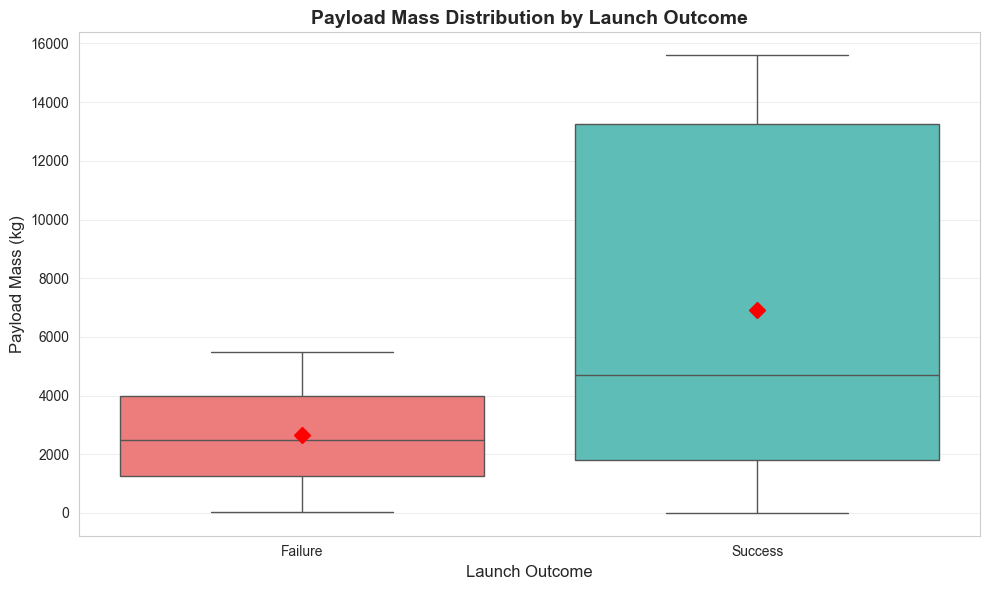


Payload Mass Statistics by Outcome:
         count     mean      std   min     25%     50%      75%      max
outcome                                                                 
Failure    3.0  2665.67  2744.87  20.0  1248.5  2477.0   3988.5   5500.0
Success  185.0  6907.20  5822.44   1.0  1800.0  4696.0  13260.0  15600.0

Additional Analysis:
Total payloads analyzed: 188
Average payload mass (all): 6839.51 kg
Median payload mass (all): 4648.00 kg
Max payload mass: 15600.00 kg
Min payload mass: 1.00 kg


In [8]:
# Merge payloads with launches
payload_analysis = payloads.merge(
    launches[["id", "success"]], 
    left_on="launch_id",
    right_on="id", 
    how="inner"
)

# Clean data: remove nulls and outliers
payload_analysis = payload_analysis.dropna(subset=['mass_kg', 'success'])
payload_analysis = payload_analysis[payload_analysis['mass_kg'] > 0]

# Create success labels for better readability
payload_analysis['outcome'] = payload_analysis['success'].map({True: 'Success', False: 'Failure'})
payload_analysis = payload_analysis.dropna(subset=['outcome'])

if len(payload_analysis) == 0:
    print("No payload data available for analysis")
else:
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    
    # Check if we have both success and failure data
    outcomes = payload_analysis['outcome'].unique()
    if len(outcomes) > 1:
        box_plot = sns.boxplot(
            x="outcome", 
            y="mass_kg", 
            data=payload_analysis,
            palette=['#FF6B6B', '#4ECDC4']
        )
        
        # Add mean markers
        means = payload_analysis.groupby('outcome')['mass_kg'].mean()
        positions = {'Failure': 0, 'Success': 1}
        for outcome, mean_val in means.items():
            if outcome in positions:
                plt.plot(positions[outcome], mean_val, marker='D', color='red', markersize=8, zorder=3)
    else:
        # If only one outcome type, create a simple box plot
        box_plot = sns.boxplot(y="mass_kg", data=payload_analysis, color='steelblue')
        print(f"Note: Only {outcomes[0]} launches have payload data")

    plt.title("Payload Mass Distribution by Launch Outcome", fontsize=14, fontweight='bold')
    plt.ylabel("Payload Mass (kg)", fontsize=12)
    if len(outcomes) > 1:
        plt.xlabel("Launch Outcome", fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # Display summary statistics
    print("\nPayload Mass Statistics by Outcome:")
    print("="*60)
    summary = payload_analysis.groupby('outcome')['mass_kg'].describe()
    print(summary.round(2))

    # Additional analysis
    print("\n" + "="*60)
    print("Additional Analysis:")
    print(f"Total payloads analyzed: {len(payload_analysis)}")
    print(f"Average payload mass (all): {payload_analysis['mass_kg'].mean():.2f} kg")
    print(f"Median payload mass (all): {payload_analysis['mass_kg'].median():.2f} kg")
    print(f"Max payload mass: {payload_analysis['mass_kg'].max():.2f} kg")
    print(f"Min payload mass: {payload_analysis['mass_kg'].min():.2f} kg")

## 6. Summary and Key Insights

This analysis provides insights into:
- Launch frequency and success trends over time
- Performance differences between rocket families
- Reliability of different launch sites (if launchpad data is available)
- Relationship between payload mass and mission success